In [1]:
import re

import itertools
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from captum.attr import visualization as viz
from captum.attr import LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
from captum.attr._models.base import _get_deep_layer_name

from IPython.display import HTML

import warnings
warnings.filterwarnings("ignore")

In [2]:
#transformer = "distilbert-base-cased"
#transformer = "bert-base-cased"
tf_cfg = dict(name = 'distilbert-base-uncased-finetuned-sst-2-english', embeddings = 'distilbert.embeddings', layer_tmpl = 'distilbert.transformer.layer', layer_count = 'n_layers')
#tf_cfg = dict(name = 'bert-base-cased', embeddings = 'bert.embeddings', layer_tmpl = 'bert.encoder.layer', layer_count = 'num_hidden_layers')
#tf_cfg = dict(name = 'roberta-base',embeddings = 'roberta.embeddings',layer_tmpl = 'roberta.encoder.layer',layer_count = 'num_hidden_layers')
#transformer = "twmkn9/bert-base-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(tf_cfg['name'])
model = AutoModelForSequenceClassification.from_pretrained(tf_cfg['name'])
model.eval()
model.zero_grad()

In [3]:
def prepare_data(sents):
    data = tokenizer(sents, padding=True, return_tensors="pt")
    input_tensor = data['input_ids']
    return input_tensor, data['attention_mask']

In [4]:
def custom_forward(inputs, attention_mask=None, pos=0):
#    print("inputs", inputs.shape)
    result = model(inputs, attention_mask=attention_mask, return_dict=True)
    preds = result.logits
#    print("preds", preds.shape)
    return preds

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions


def run_attribution_model(input_seq, attention_mask, ref_token_id, layer, steps):
    try:
        ablator = LayerIntegratedGradients(custom_forward, layer)
        input_tensor = input_seq
        attention_mask = attention_mask
        attributions = ablator.attribute(
                inputs=input_tensor,
                baselines=ref_token_id,
                additional_forward_args=(attention_mask),
                target=1,
                n_steps=steps,
        )
        attributions = summarize_attributions(attributions)
    finally:
        pass

    return attributions

In [5]:
def build_dataframe(attributions, input_seq, attention_mask):

    n_sent, _ = attributions.shape
    rows = []
    for n, row in enumerate(attributions):
        sent = n % n_sent
        for m, attribution in enumerate(row):
            if attention_mask[sent, m] == 0:
                continue
            tok = input_seq[sent, m]
            rows.append([sent, m, tokenizer.decode([tok]), attribution.item()])

    attr_df = pd.DataFrame(rows, columns=['sent', 'pos', 'token', 'value'])
    return attr_df
    

In [6]:
def run_no_show(input_seq, attention_mask, reference=[tokenizer.unk_token_id], layer=None, steps=50):
    attributions = []
    for ref in reference:
        attributions.append(
                run_attribution_model(
                        input_seq,
                        attention_mask,
                        int(ref),
                        layer,
                        steps,
                    )
            )
    attributions = torch.stack(attributions)
#    print(attributions.size())
    attributions = attributions.mean(axis=0)
#    print(attributions.size())
    df = build_dataframe(attributions, input_seq, attention_mask)
    return df

In [7]:
def html_for_sentences(df, groupings):
    if len(groupings) > 1:
        output = "<div>"
        group = groupings[0]
        for g, gdf in df.groupby(group):
            output += f"<div>{group}: {g}</div><div style='padding-left:2em;'>"
            output += html_for_sentences(gdf, groupings[1:])
            output += "</div>"
        output += "</div>"
    else:
        output = "<table>"
        for label, lvl in df.groupby(groupings[0]):
            output += f"<tr><th>{label}</th>"
            for i, row in lvl.iterrows():
                pct = int(row['rel_value'] * 100)
                g = 10 + pct
                b = 150 + pct
                if row['value'] >= 0:
                    r = g
                else:
                    r = b
                a = (row['rel_value'] / 2) + 0.3
                color = ",".join(list(map(str, [r,g,b,a])))
                size = (0.5 + (row['rel_value'] / 2) + 0.3) * 1.5

                word = row['token'].strip()
                word = re.sub(r'<', '&lt;', re.sub(r'>', '&gt;', word))
                output += f"<td><span style='font-size: {size}em; color: rgba({color});'>{word}</span></td>"
            output += "</tr>"
        output += "</table>"
    return output


In [8]:
rng = np.random.default_rng()

In [9]:
%%time
sents = [
    "This movie was the best movie I have ever seen! Some scenes were ridiculous, but acting was great.",
    "This movie was the worst movie I have ever seen! The scenes were ridiculous.",
    "This movie was not the worst movie I have ever seen. The characters were well developed.",
]

input_tensor, attention_mask = prepare_data(sents)

sample_count = 3
full_df = None
for sample_size in [10]:#, 20, 30]:
    print("SAMPLE SIZE:", sample_size)
    size_df = None
    for step_count in [5]:#, 10, 20]:
        print("STEP COUNT:", step_count)
        step_df = None
        for k in range(sample_count):
            sample_df = None
            sample = rng.integers(model.config.vocab_size, size=sample_size)
            for i in range(getattr(model.config, tf_cfg['layer_count']) + 1):
                if i == 0:
                    layer = _get_deep_layer_name(model, tf_cfg['embeddings'])
                else:
                    layer = getattr(_get_deep_layer_name(model, tf_cfg['layer_tmpl']), f"{i-1}")
                df = run_no_show(
                        input_tensor,
                        attention_mask,
                        reference=sample,
                        layer=layer,
                        steps=step_count
                    )
                df['layer'] = f"layer {i}"
                df['rel_value'] = (df['value'].abs() / df['value'].abs().max()).round(2)
                if sample_df is None:
                    sample_df = df
                else:
                    sample_df = pd.concat([sample_df, df])
            sample_df['sample'] = k
            sample_df['sample_list'] = "; ".join([tokenizer.decode([t]) for t in sample])
            if step_df is None:
                step_df = sample_df
            else:
                step_df = pd.concat([step_df, sample_df])
        step_df['step_count'] = step_count
        if size_df is None:
            size_df = step_df
        else:
            size_df = pd.concat([size_df, step_df])
        size_df['sample_size'] = sample_size
    if full_df is None:
        full_df = size_df
    else:
        full_df = pd.concat([full_df, size_df])
        

SAMPLE SIZE: 10
STEP COUNT: 5
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
CPU times: user 4min 25s, sys: 1.08 s, total: 4min 26s
Wall time: 1min 7s


In [10]:
full_df

,sent,pos,token,value,layer,rel_value,sample,sample_list,step_count,sample_size
0,0,0,[CLS],0.019296,layer 0,0.05,0,resulting; ##logical; 84; expressing; leipzig;...,5,10
1,0,1,this,0.037880,layer 0,0.09,0,resulting; ##logical; 84; expressing; leipzig;...,5,10
2,0,2,movie,0.036068,layer 0,0.09,0,resulting; ##logical; 84; expressing; leipzig;...,5,10
3,0,3,was,0.038695,layer 0,0.09,0,resulting; ##logical; 84; expressing; leipzig;...,5,10
4,0,4,the,0.060244,layer 0,0.14,0,resulting; ##logical; 84; expressing; leipzig;...,5,10
...,...,...,...,...,...,...,...,...,...,...
56,2,15,were,0.000000,layer 6,0.00,2,fidelity; flores; bulldog; emphasized; landmar...,5,10
57,2,16,well,0.000000,layer 6,0.00,2,fidelity; flores; bulldog; emphasized; landmar...,5,10
58,2,17,developed,0.000000,layer 6,0.00,2,fidelity; flores; bulldog; emphasized; landmar...,5,10
59,2,18,.,0.000000,layer 6,0.00,2,fidelity; flores; bulldog; emphasized; landmar...,5,10


In [11]:
with pd.option_context('display.max_rows', 10000):
    display(full_df)

,sent,pos,token,value,layer,rel_value,sample,sample_list,step_count,sample_size
0,0,0,[CLS],0.019296,layer 0,0.05,0,resulting; ##logical; 84; expressing; leipzig;...,5,10
1,0,1,this,0.037880,layer 0,0.09,0,resulting; ##logical; 84; expressing; leipzig;...,5,10
2,0,2,movie,0.036068,layer 0,0.09,0,resulting; ##logical; 84; expressing; leipzig;...,5,10
3,0,3,was,0.038695,layer 0,0.09,0,resulting; ##logical; 84; expressing; leipzig;...,5,10
4,0,4,the,0.060244,layer 0,0.14,0,resulting; ##logical; 84; expressing; leipzig;...,5,10
5,0,5,best,0.141503,layer 0,0.34,0,resulting; ##logical; 84; expressing; leipzig;...,5,10
6,0,6,movie,0.040037,layer 0,0.10,0,resulting; ##logical; 84; expressing; leipzig;...,5,10
7,0,7,i,0.023469,layer 0,0.06,0,resulting; ##logical; 84; expressing; leipzig;...,5,10
8,0,8,have,0.008574,layer 0,0.02,0,resulting; ##logical; 84; expressing; leipzig;...,5,10
9,0,9,ever,0.029511,layer 0,0.07,0,resulting; ##logical; 84; expressing; leipzig;...,5,10


In [12]:
full_df.to_parquet("layerexpectedgradients.parquet")

In [13]:
cosine = []
for (step_count, sample_size, sent, layer), gdf in full_df.groupby(['step_count', 'sample_size', 'sent', 'layer']):
#    print(step_count, sample_size, sent, layer)
#    display(gdf)

    for left, right in itertools.combinations(range(len(gdf['sample'].unique())), 2):
#        print(left, right)
        left_vals = np.array(gdf[gdf['sample'] == left]['value'])
        right_vals = np.array(gdf[gdf['sample'] == right]['value'])
#        print(left_vals)
#        print(right_vals)
        result = scipy.spatial.distance.cosine(
                left_vals, right_vals
            )
        cosine.append(dict(step_count=step_count, sample_size=sample_size, sent=sent, layer=layer, cosine=result))
#        print(layer, result)
cosine_df = pd.DataFrame(cosine)
cosine_df['step_count'] = pd.Categorical(cosine_df['step_count'])
cosine_df['sample_size'] = pd.Categorical(cosine_df['sample_size'])
display(cosine_df)

,step_count,sample_size,sent,layer,cosine
0,5,10,0,layer 0,0.072637
1,5,10,0,layer 0,0.067986
2,5,10,0,layer 0,0.045439
3,5,10,0,layer 1,0.046198
4,5,10,0,layer 1,0.009121
...,...,...,...,...,...
58,5,10,2,layer 5,0.000935
59,5,10,2,layer 5,0.002933
60,5,10,2,layer 6,0.000000
61,5,10,2,layer 6,0.000000


In [14]:
cosine_df.groupby(["step_count", "sample_size", "sent"]).agg({'cosine': [np.mean, np.std, np.min, np.max]})

cosine                         
                                 mean       std amin      amax
step_count sample_size sent                                   
5          10          0     0.017272  0.022106  0.0  0.072637
                       1     0.020297  0.034786  0.0  0.143615
                       2     0.054726  0.076532  0.0  0.261119

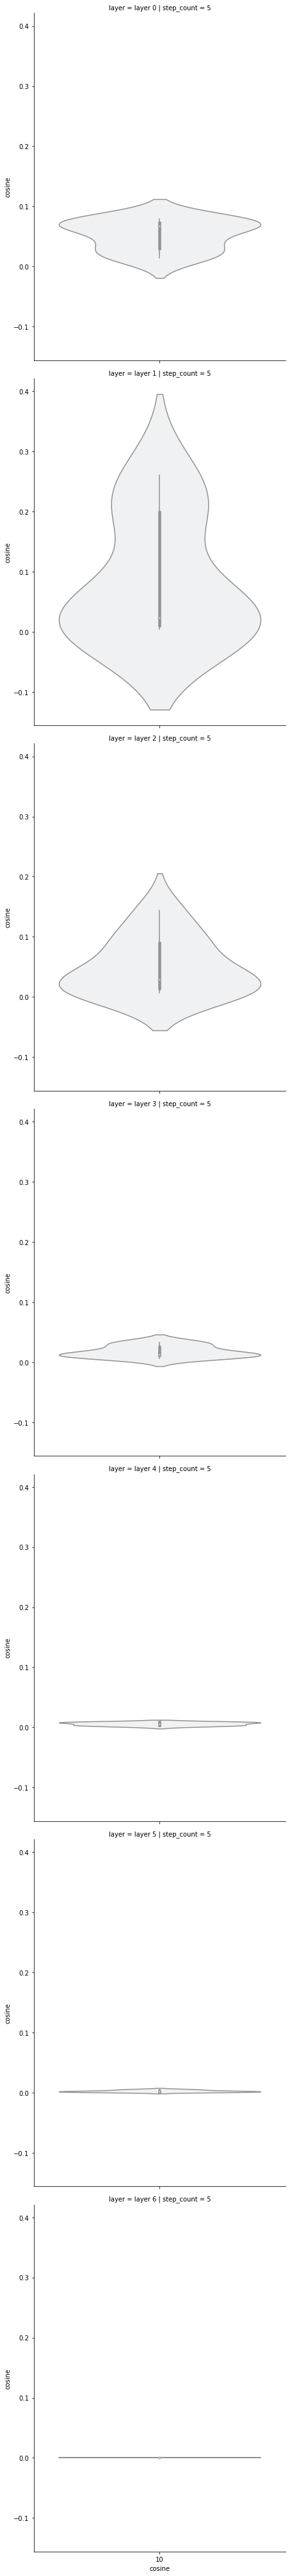

In [15]:
def make_facet(y, **kwargs):
    v = sns.violinplot(y=y,x="sample_size", hue="sample_size", **kwargs)
g = sns.FacetGrid(cosine_df, col="step_count",  row="layer", height=8, aspect=.8, sharey=True)
g.map_dataframe(make_facet, "cosine")
plt.show()

In [16]:
(full_df
     .groupby(['sample', 'sent', 'layer'])
     .agg({'value': np.max})
     .groupby(['sample', 'sent'])
     .agg({'value': [np.median, np.max, np.sum, np.std]})
)

value                              
               median      amax       sum       std
sample sent                                        
0      0     0.429571  0.669234  2.871980  0.167905
       1     0.030514  0.055711  0.164836  0.026405
       2     0.447401  0.548747  2.889323  0.139195
1      0     0.504921  0.751880  3.382289  0.171388
       1     0.016192  0.052212  0.150823  0.022154
       2     0.504919  0.654291  3.232173  0.166063
2      0     0.399508  0.694045  3.198409  0.126536
       1     0.006379  0.057939  0.137860  0.023519
       2     0.483993  0.583060  2.943547  0.149973

In [17]:
html = html_for_sentences(full_df, ["sent", "layer", "sample"])
display(HTML(html))

0,[CLS],this,movie,was,the,best,movie,i,have,ever,seen,!,some,scenes,were,ridiculous,",",but,acting,was,great,.,[SEP]
1,[CLS],this,movie,was,the,best,movie,i,have,ever,seen,!,some,scenes,were,ridiculous,",",but,acting,was,great,.,[SEP]
2,[CLS],this,movie,was,the,best,movie,i,have,ever,seen,!,some,scenes,were,ridiculous,",",but,acting,was,great,.,[SEP]
0,[CLS],this,movie,was,the,best,movie,i,have,ever,seen,!,some,scenes,were,ridiculous,",",but,acting,was,great,.,[SEP]
1,[CLS],this,movie,was,the,best,movie,i,have,ever,seen,!,some,scenes,were,ridiculous,",",but,acting,was,great,.,[SEP]
2,[CLS],this,movie,was,the,best,movie,i,have,ever,seen,!,some,scenes,were,ridiculous,",",but,acting,was,great,.,[SEP]
0,[CLS],this,movie,was,the,best,movie,i,have,ever,seen,!,some,scenes,were,ridiculous,",",but,acting,was,great,.,[SEP]
1,[CLS],this,movie,was,the,best,movie,i,have,ever,seen,!,some,scenes,were,ridiculous,",",but,acting,was,great,.,[SEP]
2,[CLS],this,movie,was,the,best,movie,i,have,ever,seen,!,some,scenes,were,ridiculous,",",but,acting,was,great,.,[SEP]
0,[CLS],this,movie,was,the,best,movie,i,have,ever,seen,!,some,scenes,were,ridiculous,",",but,acting,was,great,.,[SEP]
1,[CLS],this,movie,was,the,best,movie,i,have,ever,seen,!,some,scenes,were,ridiculous,",",but,acting,was,great,.,[SEP]


In [18]:
html = html_for_sentences(full_df, ["sample", "layer", "sent"])
display(HTML(html))